In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import mido
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

filepath = '/content/drive/My Drive/Nokia/TPD/classical/' 
modelpath = '/content/drive/My Drive/Nokia/TPD/'
filepath_jazz = '/content/drive/My Drive/Nokia/TPD/jazz/'
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))][:150]

In [5]:
import string
def msg2dict(msg):
  '''
  Returns result {note, velocity,time}, on_=true/false/none for one message passed as parameter
  '''
  result = dict()
  if 'note_on' in msg:
      on_ = True
  elif 'note_off' in msg:
      on_ = False
  else:
      on_ = None

  result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
      str.maketrans({a: None for a in string.punctuation})))

  if on_ is not None:
      for k in ['note', 'velocity']:
          result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
              str.maketrans({a: None for a in string.punctuation})))
  return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
  '''
  The function switch_note changes the last_state (the state of the 88 notes at
  the previous time step)
  based on new value of note, velocity, note_on or note_off. 
  The state of each time step contains 88 values.
  '''
  # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
  if last_state is None:
    result = [0]*88
  else:
    result = last_state.copy()
  if 21 <= note <= 108:
      result[note-21] = velocity if on_ else 0
  return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    '''converts each message in a track to a list of 88 values, and stores each 
    list in the result list in order.'''
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [7]:
def read_random_data_batch(filepath, batch_size):
  '''
  This function reads the midi files and converts to numpy array. Issuses in load function.  
  '''
  global onlyfiles
  onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))][:150]
  TOTAL_NUMBER_OF_MIDI_FILES = len(onlyfiles)
  songs = []
  idxs = np.random.choice(TOTAL_NUMBER_OF_MIDI_FILES, batch_size)
  for idx in idxs:
      mid = mido.MidiFile(filepath+onlyfiles[idx])  #SHREYA
      song = mid2arry(mid)                         #SHREYA 
        
      while song.shape[0] < 88:
           mid = mido.MidiFile(filepath+onlyfiles[np.random.randint(0, len(onlyfiles))])  
           song = mid2arry(mid)                         

      song = np.array(song)/127.0

      if song.shape[0] > 88:
          start = np.random.randint(0, song.shape[0]-(88))
          song = song[start:start+(88),:]
          song = song.reshape(88,88,-1)
      songs.append(song)
  return np.array(songs), np.zeros(batch_size)  

def display_images(images):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2])
    random_indices = np.random.choice(images.shape[0], 8)
    idx = 0
    plt.figure(figsize=(8, 6))
    for i in range(2):
        for j in range(4):
            plt.subplot(2, 4, 4*i+j+1)
            plt.imshow(images[random_indices[idx]])
            idx += 1
    plt.show()



def display_pair(original, generated):
    original = original.reshape(original.shape[0], original.shape[1], original.shape[2])
    generated = generated.reshape(generated.shape[0], generated.shape[1], generated.shape[2])
    random_indices = np.random.choice(original.shape[0], 6)
    idx = 0
    plt.figure(figsize=(8, 6))
    plt.ylim(0,127)
    for i in range(3):
        for j in range(2):
            plt.subplot(3, 4, 4*i+2*j+1)
            plt.imshow(original[random_indices[idx]])
            plt.subplot(3, 4, 4*i+2*j+2)
            plt.imshow(generated[random_indices[idx]])
            idx += 1
    plt.show()
#display_pair(result_array,result_array)


#songs, labels = read_random_data_batch(filepath, 5)
#print(songs.shape)
#display_pair(songs, songs)

In [8]:
def encoder(input_tensor, output_size):
    '''Create encoder network.
    Args:
        input_tensor: a batch of images [batch_size, 88, 88, 1]
    Returns:
        A tensor that expresses the encoder network
    '''
    net = tf.layers.conv2d(input_tensor, 8, 3, strides=1, activation=tf.nn.elu)
    print("E1 - Conv2D", net.get_shape())
    net = tf.layers.conv2d(net, 16, 3, strides=1, activation=tf.nn.elu)
    print("Conv2D", net.get_shape())
    net = tf.layers.batch_normalization(net, name='bn1')
    print("E2 -normalization ", net.get_shape())
    net = tf.layers.conv2d(net, 32, 3, strides=1, padding='VALID', activation=tf.nn.elu)
    print("E3 - conv2d ", net.get_shape())
    net = layers.dropout(net, keep_prob=0.9)
    print("dropout", net.get_shape())
    net = tf.layers.conv2d(net, 64, 3, strides=2, padding='VALID', activation=tf.nn.elu)
    print("E4 - conv2d", net.get_shape())
    net = tf.layers.batch_normalization(net, name='bn2')
    print("normalization", net.get_shape())
    net = tf.layers.conv2d(net, 128, 5, strides=1, padding='VALID', activation=tf.nn.elu)
    print("E5 - conv2d ", net.get_shape())
    
    net = tf.layers.conv2d(net, 64, 5, strides=2, padding='VALID', activation=tf.nn.elu)
    print("Conv2D", net.get_shape())
    net = tf.layers.batch_normalization(net, name='bn3')
    print("E6 - normalization ", net.get_shape())
    #net = layers.dropout(net, keep_prob=0.9)
    net = tf.layers.conv2d(net, 32, 3, strides=2, padding='VALID', activation=tf.nn.elu)
    print("Conv2D", net.get_shape())
    #print("E5 - ", net.get_shape())
    net = layers.flatten(net)
    print("E7 - flatten", net.get_shape())
    net = layers.fully_connected(net, output_size, activation_fn=None, reuse=None)
    print("fully_connected", net.get_shape())
    return net

def decoder(input_tensor):
    '''Create decoder network.
        If input tensor is provided then decodes it, otherwise samples from
        a sampled vector.
    Args:
        input_tensor: a batch of vectors to decode
    Returns:
        A tensor that expresses the decoder network 
    '''
    
    net = tf.expand_dims(input_tensor, 1)
    net = tf.expand_dims(net, 1)
    net = tf.reshape(net, [-1, 8, 8, 4])
    print("D1 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 128, 4, padding='VALID', stride=1)
    print("D2 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 64, 3, stride=2)
    print("D3 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 32, 3, stride=2)
    print("D5 - ", net.get_shape())
    net = layers.conv2d_transpose(
        net, 1, 5, stride=2, activation_fn=tf.nn.sigmoid)
    print("D6 - ", net.get_shape())
    net = tf.reshape(net, [-1, 88, 88, 1])
    return net


def discriminator(input_tensor):
    '''Create encoder network.
    Args:
        input_tensor: a batch of images [batch_size, 32, 32, 3]
    Returns:
        A tensor that expresses the encoder network
    '''
    net = layers.conv2d(input_tensor, 8, 5, stride=1, activation_fn=tf.nn.elu)
    print("DI1 - ", net.get_shape())
    net = layers.conv2d(net, 16, 5, stride=2, activation_fn=tf.nn.elu)
    print("DI2 - ", net.get_shape())
    net = layers.conv2d(net, 32, 5, stride=1, padding='VALID', activation_fn=tf.nn.elu)
    print("DI3 - ", net.get_shape())
    net = layers.dropout(net, keep_prob=0.9)
    
    net = layers.conv2d(net, 64, 3, stride=2, padding='VALID', activation_fn=tf.nn.elu)
    print("DI4 - ", net.get_shape())
    
    net = layers.conv2d(net, 32, 3, stride=1, padding='VALID', activation_fn=tf.nn.elu)
    print("DI5 - ", net.get_shape())
    
    net = layers.conv2d(net, 8, 3, stride=2, padding='VALID', activation_fn=tf.nn.elu)
    print("DI6 - ", net.get_shape())
    net = layers.flatten(net)
    print("DI7 - ", net.get_shape())
    net = tf.layers.dense(inputs=net, units=1, name='fc_discriminator')
    return net

In [9]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import losses
from tensorflow.contrib.framework import arg_scope

In [10]:

class VAEGAN():

    def __init__(self, sess, hidden_size, batch_size, learning_rate):
        
        self.sess = sess
        
        self.input_tensor = tf.placeholder(tf.float32, [None, 88, 88, 1])
        self.generator_learning_rate = tf.placeholder(tf.float32, [])
        self.discriminator_learning_rate = tf.placeholder(tf.float32, [])
        

        with arg_scope([layers.conv2d, layers.conv2d_transpose],
                       activation_fn=tf.nn.elu,
                       normalizer_fn=layers.batch_norm,
                       normalizer_params={'scale': True}):
            
            with tf.variable_scope("model"):
                D1 = discriminator(self.input_tensor)  # positive examples
                D_params_num = len(tf.trainable_variables())
                G = decoder(tf.random_normal([batch_size, hidden_size]))
                self.sampled_tensor = G
            
            with tf.variable_scope("model", reuse=True):
                D2 = discriminator(G)
                G_params_num = len(tf.trainable_variables())
            
            
            with tf.variable_scope("model", reuse=False):
                encoded = encoder(self.input_tensor, hidden_size * 2)
                mean = encoded[:, :hidden_size]
                stddev = tf.sqrt(tf.exp(encoded[:, hidden_size:]))
                
            with tf.variable_scope("model", reuse=True):
                epsilon = tf.random_normal([tf.shape(mean)[0], hidden_size])
                input_sample = mean + epsilon * stddev

                self.output_tensor = decoder(input_sample)
            
            with tf.variable_scope("model", reuse=True):
                self.sampled_tensor = decoder(tf.random_normal(
                    [batch_size, hidden_size]))

            
        D_loss = self.__get_discriminator_loss(D1, D2)
        G_loss = self.__get_generator_loss(D2)

        params = tf.trainable_variables()
        D_params = params[:D_params_num]
        G_params = params[D_params_num:G_params_num]

        global_step = tf.contrib.framework.get_or_create_global_step()
        self.train_discrimator = layers.optimize_loss(
            D_loss, global_step, self.discriminator_learning_rate, 'Adam', variables=D_params, update_ops=[])
        self.train_generator = layers.optimize_loss(
            G_loss, global_step, self.generator_learning_rate, 'Adam', variables=G_params, update_ops=[])

        vae_loss = self.__get_vae_cost(mean, stddev)
        rec_loss = self.__get_reconstruction_cost(
            self.output_tensor, self.input_tensor)

        loss = vae_loss + rec_loss
        self.train = layers.optimize_loss(loss, global_step, learning_rate=learning_rate, optimizer='Adam', update_ops=[])
        print("Model constructed")
        
    def initialize_all_variables(self):
        self.sess.run(tf.global_variables_initializer())

    def __get_discriminator_loss(self, D1, D2):
        '''Loss for the discriminator network
        Args:
            D1: logits computed with a discriminator networks from real images
            D2: logits computed with a discriminator networks from generated images
        Returns:
            Cross entropy loss, positive samples have implicit labels 1, negative 0s
        '''
        return (tf.losses.sigmoid_cross_entropy(tf.ones(tf.shape(D1)), D1) +
                tf.losses.sigmoid_cross_entropy(tf.zeros(tf.shape(D1)), D2))

    def __get_generator_loss(self, D2):
        '''Loss for the genetor. Maximize probability of generating images that
        discrimator cannot differentiate.
        Returns:
            see the paper
        '''
        return tf.losses.sigmoid_cross_entropy(tf.ones(tf.shape(D2)), D2)
        #return losses.sigmoid_cross_entropy(D2, tf.ones(tf.shape(D2)))

    def update_params_gan(self, inputs, discriminator_learning_rate, generator_learning_rate, update_disc=True):
        d_loss_value = 0
        if update_disc:
            d_loss_value = self.sess.run(self.train_discrimator, {
                    self.input_tensor: inputs, self.discriminator_learning_rate: discriminator_learning_rate})

        g_loss_value = self.sess.run(self.train_generator, {self.generator_learning_rate: generator_learning_rate})

        return g_loss_value, d_loss_value
    
    def __get_vae_cost(self, mean, stddev, epsilon=1e-8):
        '''VAE loss
        Args:
            mean:
            stddev:
            epsilon:
        '''
        return tf.reduce_sum(0.5 * (tf.square(mean) + tf.square(stddev) -
                                    2.0 * tf.log(stddev + epsilon) - 1.0))

    def __get_reconstruction_cost(self, output_tensor, target_tensor, epsilon=1e-8):
        '''Reconstruction loss
        Cross entropy reconstruction loss
        Args:
            output_tensor: tensor produces by decoder
            target_tensor: the target tensor that we want to reconstruct
            epsilon:
        '''
        return tf.reduce_sum(-target_tensor * tf.log(output_tensor + epsilon) -
                             (1.0 - target_tensor) * tf.log(1.0 - output_tensor + epsilon))

    def update_params_vae(self, input_tensor):
        '''Update parameters of the network
        Args:
            input_tensor: a batch of flattened images [batch_size, 28*28]
        Returns:
            Current loss value
        '''
        return self.sess.run(self.train, {self.input_tensor: input_tensor})
    
    def run_CVAE(self, input_tensor):
        return self.sess.run(self.output_tensor, {self.input_tensor: input_tensor})
    
    def generate_and_show_images(self, num_samples):
        '''Generates the images using the model and saves them in the directory
        Args:
            num_samples: number of samples to generate
            directory: a directory to save the images
        '''
        imgs = self.sess.run(self.sampled_tensor)
        imgs = imgs.reshape([-1, 88, 88, 1])
        display_images(imgs)
    
    def get_generated_images(self):
        imgs = self.sess.run(self.sampled_tensor)
        return imgs

# Do not run this block anymore. This was for first round of training. 
#### if we run this again, we will lose all learnt parameetrs of teh model till now and start from scratch.

run the cell after this. where we load from drive and then train for next 10 epochs and save back to drive

In [11]:
'''from keras.utils.vis_utils import plot_model
batch_size = 16
hidden_size = 256
learning_rate = 5e-4
gen_learning_rate = 5e-4
disc_learning_rate = 5e-5
max_epoch = 5
updates_per_epoch = int(len(onlyfiles)/batch_size)

sess = tf.Session()

VAE_INTERVAL = 2

model = VAEGAN(sess, hidden_size, batch_size, learning_rate)
model.initialize_all_variables()
generator_learning_rate = gen_learning_rate
discriminator_learning_rate = disc_learning_rate
print("model initialized##################")
with tf.device('/gpu:0'):
    
    training_loss_hist_vae = []
    training_loss_hist_gan_g = []
    training_loss_hist_gan_d = []
    
    for epoch in range(max_epoch):
            training_loss_vae = 0.0
            training_loss_gan_g_loss = 0.0
            training_loss_gan_d_loss = 0.0
            generator_learning_rate = max(learning_rate, min(learning_rate * (training_loss_gan_g_loss / training_loss_gan_d_loss), gen_learning_rate*20))
            discriminator_learning_rate = min(learning_rate, learning_rate * (training_loss_gan_d_loss/training_loss_gan_g_loss))
            for i in range(updates_per_epoch):
                loss_value_vae, loss_value_gan_d_loss = 0, 0
                images, _ = read_random_data_batch(filepath, batch_size)
                if i % VAE_INTERVAL == 0:
                    loss_value_vae = model.update_params_vae(images)
                    training_loss_vae += loss_value_vae
                loss_value_gan_g_loss, loss_value_gan_d_loss = model.update_params_gan(images, discriminator_learning_rate, generator_learning_rate, True)
                training_loss_gan_g_loss += loss_value_gan_g_loss
                training_loss_gan_d_loss += loss_value_gan_d_loss
            
            print("##### EPOCH - ", epoch, " ######")
            
            ground_images, _ = read_random_data_batch(filepath, batch_size)
            cvae_images = model.run_CVAE(ground_images)
            
            print("DISPLAYING GROUND / CVAE")
            display_pair(ground_images, cvae_images)
            
            print("DISPLAYING GENERATED")
            model.generate_and_show_images(batch_size)
            
            training_loss_vae = training_loss_vae / \
                (int(updates_per_epoch/2) * batch_size)
                
            training_loss_gan_g_loss = training_loss_gan_g_loss / \
                (int(updates_per_epoch) * batch_size)
                
            training_loss_gan_d_loss = training_loss_gan_d_loss / \
                (int(updates_per_epoch) * batch_size)
            
            training_loss_hist_vae.append(training_loss_vae)
            training_loss_hist_gan_g.append(training_loss_gan_g_loss)
            training_loss_hist_gan_d.append(training_loss_gan_d_loss)
            generator_learning_rate = max(gen_learning_rate, min(gen_learning_rate * (training_loss_gan_g_loss / training_loss_gan_d_loss), gen_learning_rate*10))
            discriminator_learning_rate = min(disc_learning_rate, disc_learning_rate * (training_loss_gan_d_loss/training_loss_gan_g_loss))
            
            print("Loss VAE %f" % training_loss_vae)
            print("Loss GAN GEN %f" % training_loss_gan_g_loss)
            print("Loss GAN DISC %f" % training_loss_gan_d_loss)
            
            plt.subplot(2, 1, 1)
            plt.plot(training_loss_hist_vae, c='blue')
            plt.xlim([0, max_epoch])
            plt.subplot(2, 1, 2)
            plt.plot(training_loss_hist_gan_g, c='red')
            plt.plot(training_loss_hist_gan_d, c='green')
            plt.xlim([0, max_epoch])
            plt.show()



saver = tf.train.Saver()
save_path = saver.save(model.sess, "./model/model_songs_cvae_gan_song.ckpt")
print("Model Saved")

drivesaver = tf.train.Saver()
drivepath = drivesaver.save(model.sess,modelpath+"classicalModel/model_songs_cvae_gan_song.ckpt")'''


'from keras.utils.vis_utils import plot_model\nbatch_size = 16\nhidden_size = 256\nlearning_rate = 5e-4\ngen_learning_rate = 5e-4\ndisc_learning_rate = 5e-5\nmax_epoch = 5\nupdates_per_epoch = int(len(onlyfiles)/batch_size)\n\nsess = tf.Session()\n\nVAE_INTERVAL = 2\n\nmodel = VAEGAN(sess, hidden_size, batch_size, learning_rate)\nmodel.initialize_all_variables()\ngenerator_learning_rate = gen_learning_rate\ndiscriminator_learning_rate = disc_learning_rate\nprint("model initialized##################")\nwith tf.device(\'/gpu:0\'):\n    \n    training_loss_hist_vae = []\n    training_loss_hist_gan_g = []\n    training_loss_hist_gan_d = []\n    \n    for epoch in range(max_epoch):\n            training_loss_vae = 0.0\n            training_loss_gan_g_loss = 0.0\n            training_loss_gan_d_loss = 0.0\n            generator_learning_rate = max(learning_rate, min(learning_rate * (training_loss_gan_g_loss / training_loss_gan_d_loss), gen_learning_rate*20))\n            discriminator_learni

## Run from here. 

In [12]:
sess = tf.Session()
batch_size = 16
hidden_size = 256
learning_rate = 1e-5
max_epoch = 5
updates_per_epoch = int(len(onlyfiles)/batch_size)
model = VAEGAN(sess, hidden_size, batch_size, learning_rate)
tf_saver = tf.train.Saver()
tf_saver.restore(sess, modelpath+"classicalModel/model_songs_cvae_gan_song.ckpt")

Instructions for updating:
Please use `layer.__call__` method instead.
DI1 -  (?, 88, 88, 8)
DI2 -  (?, 44, 44, 16)
DI3 -  (?, 40, 40, 32)
DI4 -  (?, 19, 19, 64)
DI5 -  (?, 17, 17, 32)
DI6 -  (?, 8, 8, 8)
Instructions for updating:
Use keras.layers.flatten instead.
DI7 -  (?, 512)
Instructions for updating:
Use keras.layers.Dense instead.
D1 -  (16, 8, 8, 4)
D2 -  (16, 11, 11, 128)
D3 -  (16, 22, 22, 64)
D5 -  (16, 44, 44, 32)
D6 -  (16, 88, 88, 1)
DI1 -  (16, 88, 88, 8)
DI2 -  (16, 44, 44, 16)
DI3 -  (16, 40, 40, 32)
DI4 -  (16, 19, 19, 64)
DI5 -  (16, 17, 17, 32)
DI6 -  (16, 8, 8, 8)
DI7 -  (16, 512)
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
E1 - Conv2D (?, 86, 86, 8)
Conv2D (?, 84, 84, 16)
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
E2 -normalization  (?, 84, 84, 16)
E3 - conv2d  (?

### Training the model

##### EPOCH -  0  ######
DISPLAYING GROUND / CVAE


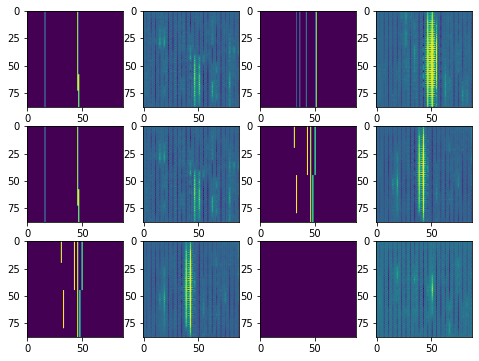

DISPLAYING GENERATED


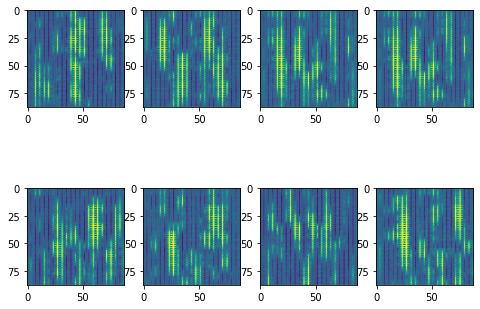

Loss VAE 10673.385010
Loss GAN GEN 0.170623
Loss GAN DISC 0.029254


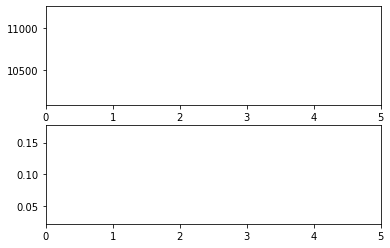

##### EPOCH -  1  ######
DISPLAYING GROUND / CVAE


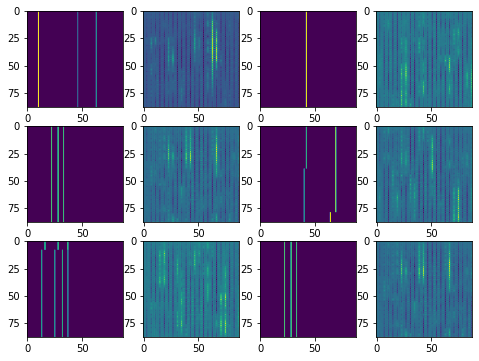

DISPLAYING GENERATED


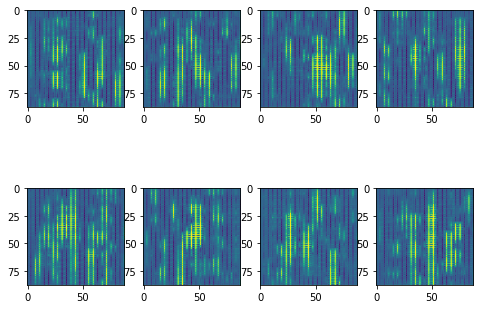

Loss VAE 10638.733643
Loss GAN GEN 0.173616
Loss GAN DISC 0.025520


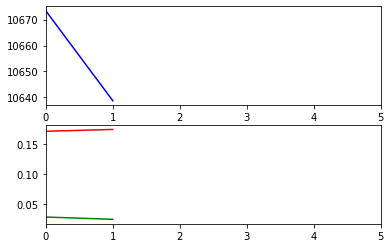

##### EPOCH -  2  ######
DISPLAYING GROUND / CVAE


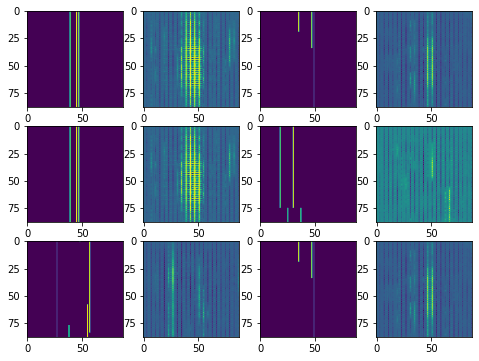

DISPLAYING GENERATED


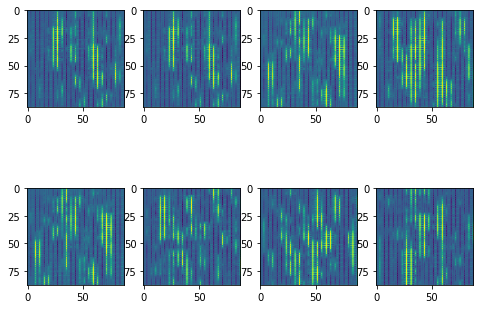

Loss VAE 10463.136841
Loss GAN GEN 0.182004
Loss GAN DISC 0.021458


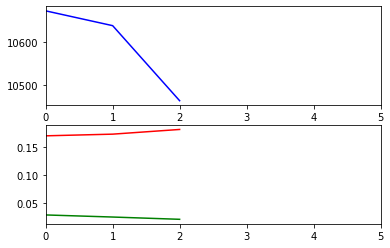

##### EPOCH -  3  ######
DISPLAYING GROUND / CVAE


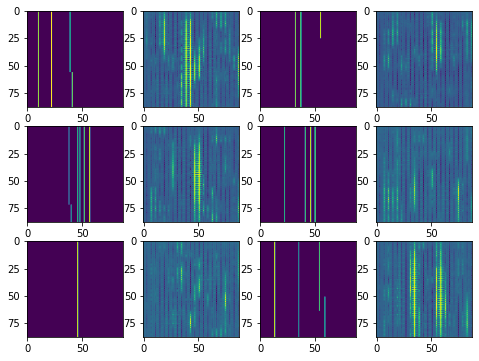

DISPLAYING GENERATED


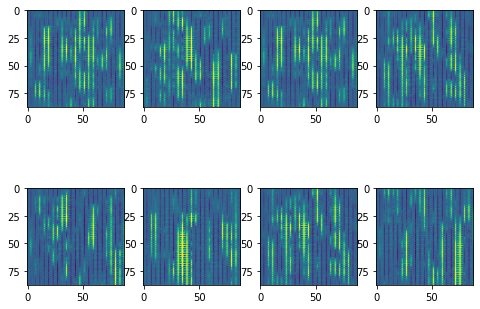

Loss VAE 10359.276978
Loss GAN GEN 0.174457
Loss GAN DISC 0.022493


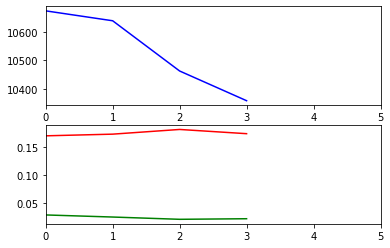

##### EPOCH -  4  ######
DISPLAYING GROUND / CVAE


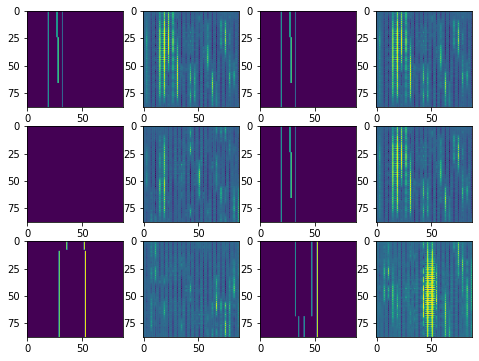

DISPLAYING GENERATED


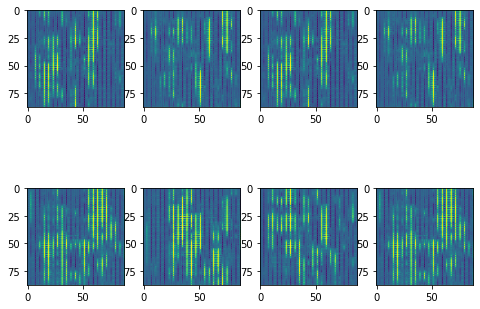

Loss VAE 10328.913696
Loss GAN GEN 0.182603
Loss GAN DISC 0.021762


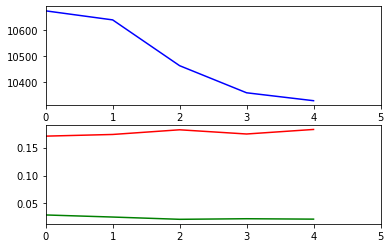

Model Saved


In [ ]:
batch_size = 16
hidden_size = 128
learning_rate = 5e-5
gen_learning_rate = 5e-5
disc_learning_rate = 5e-6
max_epoch = 5
updates_per_epoch = int(len(onlyfiles)/batch_size)

#sess = tf.Session()

VAE_INTERVAL = 1

generator_learning_rate = gen_learning_rate
discriminator_learning_rate = disc_learning_rate

with tf.device('/gpu:0'):
    
    training_loss_hist_vae = []
    training_loss_hist_gan_g = []
    training_loss_hist_gan_d = []
    
    for epoch in range(max_epoch):
            print("##### EPOCH - ", epoch, " ######")
            training_loss_vae = 0.0
            training_loss_gan_g_loss = 0.00001
            training_loss_gan_d_loss = 0.00001
            generator_learning_rate = max(learning_rate, min(learning_rate * (training_loss_gan_g_loss / training_loss_gan_d_loss), gen_learning_rate*20))
            discriminator_learning_rate = min(learning_rate, learning_rate * (training_loss_gan_d_loss/training_loss_gan_g_loss))
            for i in range(updates_per_epoch):
                loss_value_vae, loss_value_gan_d_loss = 0, 0
                images, _ = read_random_data_batch(filepath, batch_size)
                if i % VAE_INTERVAL == 0:
                    loss_value_vae = model.update_params_vae(images)
                    training_loss_vae += loss_value_vae
                loss_value_gan_g_loss, loss_value_gan_d_loss = model.update_params_gan(images, discriminator_learning_rate, generator_learning_rate, True)
                training_loss_gan_g_loss += loss_value_gan_g_loss
                training_loss_gan_d_loss += loss_value_gan_d_loss
            
            
            
            ground_images, _ = read_random_data_batch(filepath, batch_size)
            cvae_images = model.run_CVAE(ground_images)
            
            print("DISPLAYING GROUND / CVAE")
            display_pair(ground_images, cvae_images)
            
            print("DISPLAYING GENERATED")
            model.generate_and_show_images(batch_size)
            
            training_loss_vae = training_loss_vae / \
                (int(updates_per_epoch/2) * batch_size)
                
            training_loss_gan_g_loss = training_loss_gan_g_loss / \
                (int(updates_per_epoch) * batch_size)
                
            training_loss_gan_d_loss = training_loss_gan_d_loss / \
                (int(updates_per_epoch) * batch_size)
            
            training_loss_hist_vae.append(training_loss_vae)
            training_loss_hist_gan_g.append(training_loss_gan_g_loss)
            training_loss_hist_gan_d.append(training_loss_gan_d_loss)
            generator_learning_rate = max(gen_learning_rate, min(gen_learning_rate * (training_loss_gan_g_loss / training_loss_gan_d_loss), gen_learning_rate*10))
            discriminator_learning_rate = min(disc_learning_rate, disc_learning_rate * (training_loss_gan_d_loss/training_loss_gan_g_loss))
            
            print("Loss VAE %f" % training_loss_vae)
            print("Loss GAN GEN %f" % training_loss_gan_g_loss)
            print("Loss GAN DISC %f" % training_loss_gan_d_loss)
            
            plt.subplot(2, 1, 1)
            plt.plot(training_loss_hist_vae, c='blue')
            plt.xlim([0, max_epoch])
            plt.subplot(2, 1, 2)
            plt.plot(training_loss_hist_gan_g, c='red')
            plt.plot(training_loss_hist_gan_d, c='green')
            plt.xlim([0, max_epoch])
            plt.show()


drivesaver = tf.train.Saver()
drivepath = drivesaver.save(model.sess,modelpath+"classicalModel/model_songs_cvae_gan_song.ckpt")
print("Model Saved")

In [ ]:
drivesaver = tf.train.Saver()
drivepath = drivesaver.save(model.sess,modelpath+"classicalModel/model_songs_cvae_gan_song.ckpt")

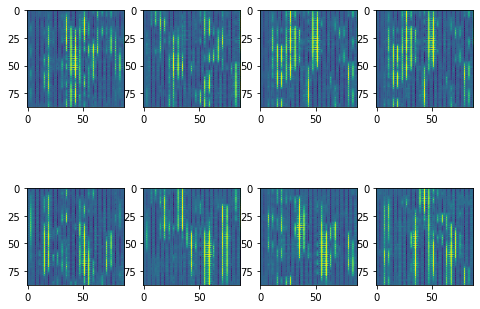

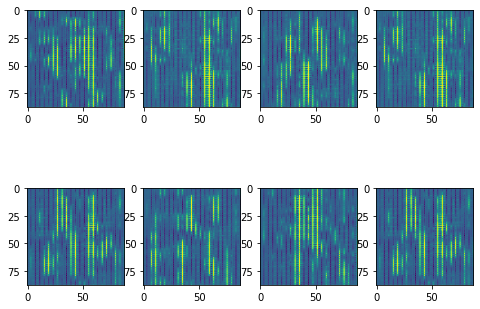

In [ ]:
for i in range(2):
    model.generate_and_show_images(batch_size)  

In [ ]:
songs = model.get_generated_images()
print(np.mean(songs[0]))

0.41262925


In [13]:
import matplotlib.pyplot as plt

def threshold(a, threshmin=None, threshmax=None, newval=0):
    a = np.ma.array(a, copy=True)
    mask = np.zeros(a.shape, dtype=bool)
    if threshmin is not None:
        mask |= (a < threshmin).filled(False)

    if threshmax is not None:
        mask |= (a > threshmax).filled(False)

    a[mask] = newval
    return a

In [14]:
##### added for testing

def test_song(mid):
      song = mid2arry(mid)                                           
      songs = []
      song = np.array(song)/127.0
      start = 0
      #print(song.shape[0])
      while start < (song.shape[0]-88) and song.shape[0] > 88 :
          #start = np.random.randint(0, song.shape[0]-(88))
          song_part = song[start:start+(88),:]
          song_part = song_part.reshape(88,88,-1)
          songs.append(song_part)
          start = start + 88
      return np.array(songs), np.zeros(batch_size) 

After thresholding


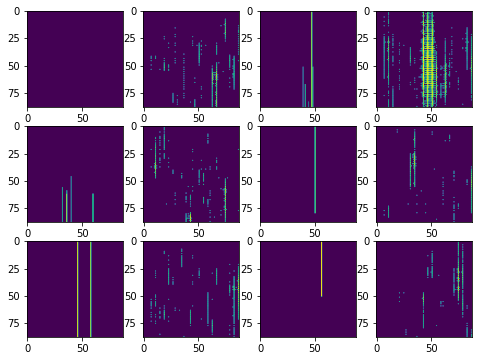

In [16]:
#ground_images, _ = read_random_data_batch(filepath_jazz, batch_size)
myinput = mido.MidiFile(filepath_jazz+"Aliceinw.mid")
ground_images, _ = test_song(myinput)
cvae_images = model.run_CVAE(ground_images)

#display_pair(ground_images*127, cvae_images*127)


thresholded_songs = []
for each_song,input_song in zip(cvae_images, ground_images):
    each_song *= 127
    each_song = each_song.astype(int)
    input_song *=127
    input_song = input_song.astype(int)
    thresholded_song = threshold(each_song,60, 127, 0) ############### Thresholdingggggg
    thresholded_songs.append(thresholded_song)
thresholded_songs = np.array(thresholded_songs)
#display_images(thresholded_songs)

print("After thresholding")
display_pair(ground_images, thresholded_songs)

In [17]:
np.save(open("original.npy", "wb"), ground_images[0])
np.save(open("gen.npy", "wb"), thresholded_songs[0])

### converting output of model into midi file

#### needs improvement in outputs

In [18]:
from mido import Message, MidiFile, MidiTrack
from mido import MetaMessage
from mido import bpm2tempo

songcount = 2
def convertImage2midi( myimage, mode):
    global songcount
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    #mytempo = bpm2tempo(90)
    #track.append(MetaMessage('set_tempo', tempo=mytempo, time=0))
    #track.append(Message('program_change', program=12, time=0))
    noteon = 0
    noteoff =0
    for i in range (0,88):
      for j in range (0,88):
        if (myimage[i][j][0] > 0 and myimage[i][j][0] <=127):
            track.append(Message('note_on', note=i+21, velocity=myimage[i][j][0], time=j))
            noteon = noteon+1
            
        else:
            track.append(Message('note_off', note=i+21, velocity=0, time=j))
            #print("note = {},velocity={},time={}".format(i,myimage[i][j][0],j))
            noteoff = noteoff+1

    print("noteon = {}, noteoff={}".format(noteon, noteoff))
    if mode ==1 :
        mid.save('input_file'+str(songcount)+'.mid')
    else:
        mid.save('converted_file'+str(songcount)+'.mid')
    

def image2midi(model_input, model_output):
    global songcount
    print("for input file:")
    convertImage2midi(model_input, 1)
    print("for output file:")
    convertImage2midi(model_output,2)
    songcount =  songcount + 1

image2midi(ground_images[0].astype(int),thresholded_songs[0].astype(int))


for input file:
noteon = 176, noteoff=7568
for output file:
noteon = 279, noteoff=7465
